In [1]:
!pip install transformers

In [2]:
import torch
# If there's a GPU available...
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [3]:
import logging
import time
from platform import python_version
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from sklearn.metrics import roc_auc_score
from torch.autograd import Variable

In [4]:
#load the dataset from google drive  
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/doc-chatbot/Emotion Phrases.csv',header=None)
df.head()

,0,1
0,joy,[ On days when I feel close to my partner and ...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


In [5]:
#assign the column names to dataset
df.columns=['emotion','phrase']



In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
nltk.download('stopwords')
nltk.download('wordnet')
stop=stopwords.words('english')
lem=WordNetLemmatizer()
#perform preprocessing
def clean_text(phrase):
  tokens=gensim.utils.simple_preprocess(phrase)

  clean_tokens=[token for token in tokens if token not in stop]
  #lemmed_tokens=[lem.lemmatize(word) for word in clean_tokens]
  sentence=' '.join(clean_tokens)

  
  return sentence

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
#apply the text prerpocessing and shuffle the dataset
from sklearn.utils import shuffle

df['phrase']=df['phrase'].apply(lambda x:clean_text(x))
df = shuffle(df)
df.head()

,emotion,phrase
6164,anger,dancing dame social one friends interested cam...
3596,guilt,thought could avoided situation one fear conce...
5165,guilt,committed sin immorality mentioned
4964,joy,someone love
6685,joy,time learnt passed malawi school leaving certi...


In [8]:
#map the lables to numbers and store it a dictionary
#possible_labels = df.sentiment.unique()
possible_labels = df.emotion.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict


{'anger': 0,
 'disgust': 4,
 'fear': 5,
 'guilt': 1,
 'joy': 2,
 'sadness': 6,
 'shame': 3}

In [9]:
#labels=df.emotion.unique()
labels=['fear', 'sadness', 'shame', 'anger', 'disgust', 'guilt', 'joy']

In [10]:
#replace the categorical labels with numarical
#df['emotion'] = df.emotion.replace(label_dict)

In [11]:
#check the length of the large setence in the dataframe beofre adding spl tokens
#max_len=max([len(s.split())for s in df['phrase']])
max_len=128


In [12]:
df=df.join(pd.get_dummies(df['emotion']))
df=df.drop(['emotion'], axis = 1) 

In [13]:
df.head()

,phrase,anger,disgust,fear,guilt,joy,sadness,shame
6164,dancing dame social one friends interested cam...,1,0,0,0,0,0,0
3596,thought could avoided situation one fear conce...,0,0,0,1,0,0,0
5165,committed sin immorality mentioned,0,0,0,1,0,0,0
4964,someone love,0,0,0,0,1,0,0
6685,time learnt passed malawi school leaving certi...,0,0,0,0,1,0,0


In [14]:
df_train = df.sample(frac=.30)
df_val = df.sample(frac=.10)
df_test = df.sample(frac=.10)

In [15]:
model_class = transformers.BertModel
tokenizer_class = transformers.BertTokenizer
pretrained_weights='bert-base-uncased'
# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
bert_model = model_class.from_pretrained(pretrained_weights)
bert_model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [16]:
max_seq = max_len
def tokenize_text(df, max_seq):
    return [
        tokenizer.encode(text, add_special_tokens=True)[:max_seq] for text in df.phrase.values
    ]
def pad_text(tokenized_text, max_seq):
    return np.array([el + [0] * (max_seq - len(el)) for el in tokenized_text])
def tokenize_and_pad_text(df, max_seq):
    tokenized_text = tokenize_text(df, max_seq)
    padded_text = pad_text(tokenized_text, max_seq)
    return torch.tensor(padded_text)
def targets_to_tensor(df, labels):
    return torch.tensor(df[labels].values, dtype=torch.float32)

In [18]:
train_indices = tokenize_and_pad_text(df_train, max_seq)
val_indices = tokenize_and_pad_text(df_val, max_seq)
test_indices = tokenize_and_pad_text(df_test, max_seq)
train_indices.to(device)
val_indices.to(device)
test_indices.to(device)
with torch.no_grad():
    x_train = bert_model(train_indices.to(device))[0]  
    x_val = bert_model(val_indices.to(device))[0]
    x_test = bert_model(test_indices.to(device))[0]
y_train = targets_to_tensor(df_train, labels)
y_val = targets_to_tensor(df_val, labels)
y_test = targets_to_tensor(df_test, labels)

In [19]:
x_train[0]

tensor([[-0.4321,  0.4302,  0.5643,  ..., -0.4960,  0.5820, -0.4106],
        [ 0.0565, -0.1511,  0.5237,  ..., -0.1308, -0.0130, -0.2247],
        [-0.5280, -0.1063,  0.5684,  ..., -0.3531, -0.1689, -0.2294],
        ...,
        [ 0.0857, -0.0011,  0.9181,  ..., -0.6338,  0.1725, -0.8110],
        [ 0.0231,  0.1394,  0.8415,  ..., -0.5871,  0.0619, -0.8199],
        [-0.0043,  0.2212,  0.8395,  ..., -0.5536,  0.0082, -0.9205]])

In [20]:
class KimCNN(nn.Module):
    def __init__(self, embed_num, embed_dim, class_num, kernel_num, kernel_sizes, dropout, static):
        super(KimCNN, self).__init__()
        V = embed_num
        D = embed_dim
        C = class_num
        Co = kernel_num
        Ks = kernel_sizes
        
        self.static = static
        self.embed = nn.Embedding(V, D)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, Co, (K, D)) for K in Ks])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(Ks) * Co, C)
        self.Softmax = nn.Softmax()
        
    def forward(self, x):
        if self.static:
            x = Variable(x)
        x = x.unsqueeze(1)  # (N, Ci, W, D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1]  # [(N, Co, W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        x = self.dropout(x)  # (N, len(Ks)*Co)
        logit = self.fc1(x)  # (N, C)
        output = self.Softmax(logit)
        return output

In [21]:
embed_num = x_train.shape[1]
embed_dim = x_train.shape[2]
class_num = y_train.shape[1]
kernel_num = 3
kernel_sizes = [2, 3, 4]
dropout = 0.3
static = True
model = KimCNN(
    embed_num=embed_num,
    embed_dim=embed_dim,
    class_num=class_num,
    kernel_num=kernel_num,
    kernel_sizes=kernel_sizes,
    dropout=dropout,
    static=static,
).to(device)

In [22]:
n_epochs = 15
batch_size = 64
lr = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

In [23]:
def generate_batch_data(x, y, batch_size):
    i, batch = 0, 0
    for batch, i in enumerate(range(0, len(x) - batch_size, batch_size), 1):
        x_batch = x[i : i + batch_size]
        y_batch = y[i : i + batch_size]
        yield x_batch, y_batch, batch
    if i + batch_size < len(x):
        yield x[i + batch_size :], y[i + batch_size :], batch + 1
    if batch == 0:
        yield x, y, 1

In [24]:
train_losses, val_losses = [], []
for epoch in range(n_epochs):
    start_time = time.time()
    train_loss = 0
    model.train(True)
    for x_batch, y_batch, batch in generate_batch_data(x_train, y_train, batch_size):
        y_pred = model(x_batch)
        y_pred=y_pred.to(device)
        optimizer.zero_grad()
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= batch
    train_losses.append(train_loss)
    elapsed = time.time() - start_time
model.eval() # disable dropout for deterministic output
# deactivate autograd engine to reduce memory usage and speed up computations
with torch.no_grad(): 
        val_loss, batch = 0, 1
        for x_batch, y_batch, batch in generate_batch_data(x_val, y_val, batch_size):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            val_loss += loss.item()
        val_loss /= batch
        val_losses.append(val_loss)
        print("Epoch %d Train loss: %.2f. Validation loss: %.2f. Elapsed time: %.2fs."% (epoch + 1, train_losses[-1], val_losses[-1], elapsed))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 10 Train loss: 0.36. Validation loss: 0.37. Elapsed time: 15.79s.


In [25]:
model.eval() # disable dropout for deterministic output
with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
    y_preds = []
    batch = 0
    for x_batch, y_batch, batch in generate_batch_data(x_test, y_test, batch_size):
        y_pred = model(x_batch)
        y_preds.extend(y_pred.cpu().numpy().tolist())
    y_preds_np = np.array(y_preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [52]:
#calculate f1 score


In [37]:
#enter the input
input_text=input('Enter the comment:')
comment=pd.Series(input_text)
comment=comment.to_frame('phrase')
#comment['phrase']=comment['phrase'].apply(lambda x:clean_text(x))
#convert to pytorch data type
comment_indices  = tokenize_and_pad_text(comment, max_seq)
comment_indices.to(device)
with torch.no_grad():
    comment_bert = bert_model(comment_indices.to(device))[0]  
#fee the data to cnn model
model.eval() # disable dropout for deterministic output
with torch.no_grad(): # deactivate autograd engine to reduce memory usage and speed up computations
    y_preds_comment = []
    batch = 0
    #for x_batch, batch in generate_batch_data(x_test, y_test, batch_size):
    y_preds_comment = model(comment_bert)
    y_preds_comment=y_preds_comment.cpu().numpy().tolist()
    y_preds_comment=y_preds_comment[0]
    
    
#sorting the list of softmax values to get max 2 probabilities
sorted_integers = sorted(y_preds_comment, reverse=True)  

largest_prob = sorted_integers[0] 
second_largest_prob = sorted_integers[1]  

#Here we are extracting the max probability value index from the list and get the key(label) from label dictionary


max_index1 = y_preds_comment.index(largest_prob)
max_index2 = y_preds_comment.index(second_largest_prob)
key_list = list(label_dict.keys()) 
val_list = list(label_dict.values()) 
  
em1=(key_list[val_list.index(max_index1)]) 
em2=(key_list[val_list.index(max_index2)]) 
print('emotions :',em1, em2)

Enter the comment:my umcle is embusing me 
emotions : anger disgust


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [40]:
#map the lables to numbers and store it a dictionary

emotions=['joy', 'disgust', 'anger', 'guilt', 'sadness', 'shame','fear']

em_dict = dict(zip(emotions, range(0,7)))
em_dict







{'anger': 2,
 'disgust': 1,
 'fear': 6,
 'guilt': 3,
 'joy': 0,
 'sadness': 4,
 'shame': 5}

In [49]:
import datetime
dates = [datetime.date( 2001,6,1), 
     datetime.date( 2001,6,2),
     datetime.date( 2001,6,3),
     datetime.date( 2001,6,4),
     datetime.date( 2001,6,5)
     ]
# emotion index for each date
emotion_index=[5,7,2,4,3]

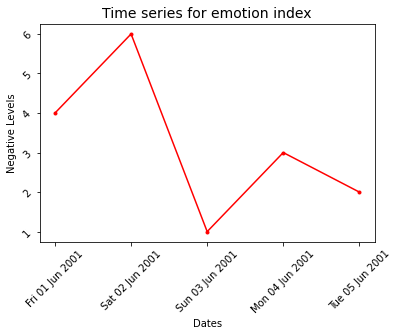

In [50]:
import matplotlib.pyplot as plt
import matplotlib.dates
%matplotlib inline
fig = plt.figure()  # a new figure window
ax = fig.add_subplot(1, 1, 1)  # specify (nrows, ncols, axnum)
# set a title for this sub-plot
ax.set_title('Time series for emotion index', fontsize=14)
# set tick for x-axis
ax.set_xticks(dates)
# set labels for x-ticks (dates) and rotate them (45 degrees) for readability
ax.set_xticklabels(dates, rotation=45, fontsize=10 )
# set a title for x-axis
ax.set_xlabel("Dates")
# set a title for y-axis
ax.set_ylabel("Negative Levels") 
ax.set_yticklabels(np.arange(10), rotation=45, fontsize=10 )               

ax.xaxis.set_major_formatter(
    matplotlib.dates.DateFormatter('%a %d %b %Y')
 )
# plot nao_index as a function of dates.
ax.plot(dates, emotion_index, 'r.-')